In [2]:
import matplotlib.pyplot as plt
import lightkurve as lk

import numpy as np

In [3]:
from TESSCroMo.tesscromo import TESSTargetPixelModeler

In [132]:
search_result = lk.search_targetpixelfile('TOI 2406', mission='TESS', )
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,TESS-SPOC,1800,212957629,0.0
1,TESS Sector 30,2020,SPOC,120,212957629,0.0
2,TESS Sector 30,2020,TESS-SPOC,600,212957629,0.0
3,TESS Sector 42,2021,SPOC,120,212957629,0.0
4,TESS Sector 42,2021,TESS-SPOC,600,212957629,0.0
5,TESS Sector 43,2021,SPOC,120,212957629,0.0
6,TESS Sector 43,2021,TESS-SPOC,600,212957629,0.0
7,TESS Sector 70,2023,SPOC,120,212957629,0.0


In [133]:
tpf = search_result[0].download()

/Users/rfwilso1/miniforge3/lib/python3.9/site-packages/lightkurve/search.py:315: LightkurveWarning: `cutout_size` can only be specified for TESS Full Frame Image cutouts.
  warnings.warn(


In [134]:
TESSCrowd = TESSTargetPixelModeler(tpf, )

In [135]:
dx, dy = TESSCrowd.estimate_offset()
tpfmodel, w1,w2 = TESSCrowd.fit_tpf_model( use_err=True, dx=dx, dy=dy)

(<AxesSubplot:title={'center':'Median TPF'}>,
 <AxesSubplot:title={'center':'Model TPF'}>,
 <AxesSubplot:title={'center':'Model$-$Data'}>)

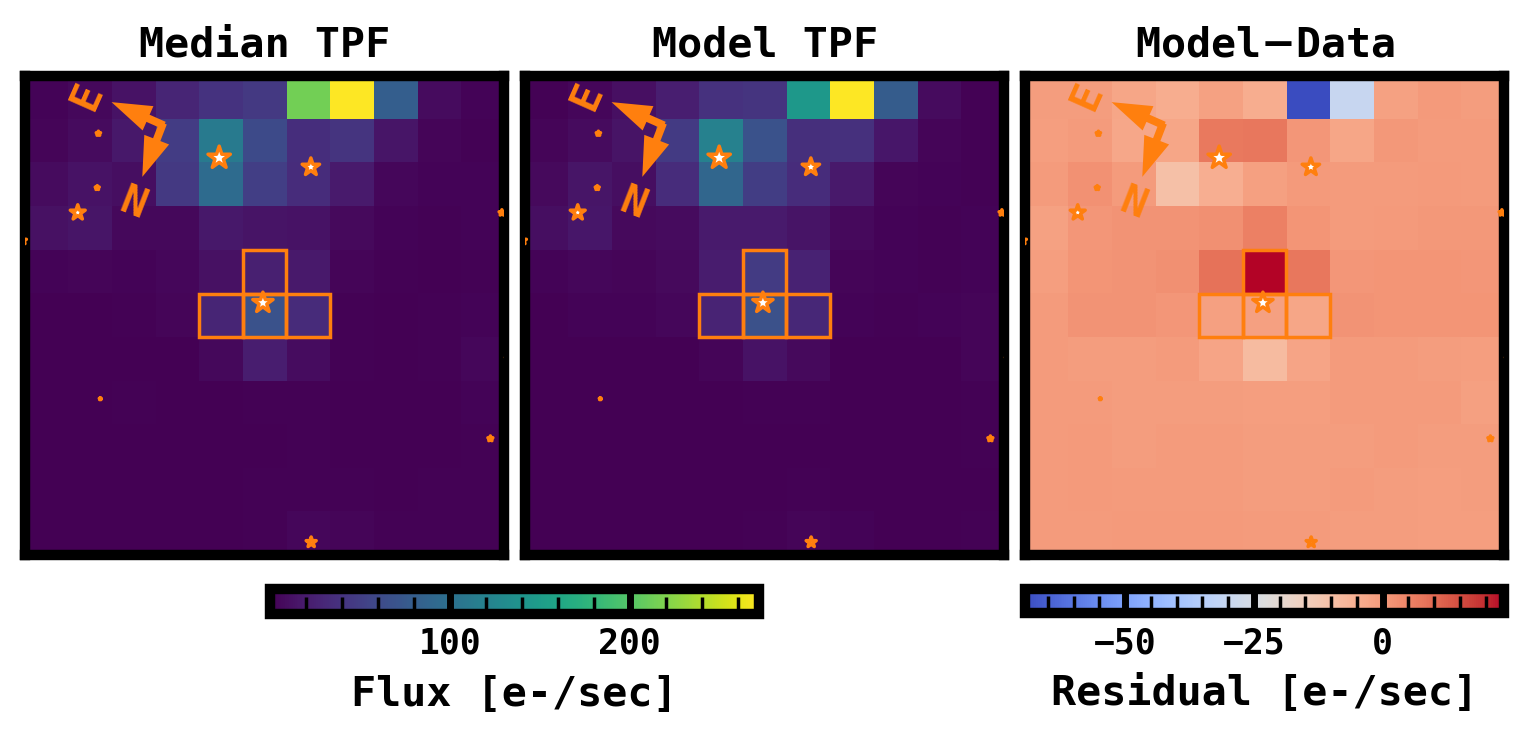

In [136]:
TESSCrowd.plot_tpf_model(logscale=False, vmax=None)

In [137]:
crowding=TESSCrowd.get_contamination_ratio(aperture=tpf.pipeline_mask)

Text(0.5, 1.0, 'CroMo Aperture')

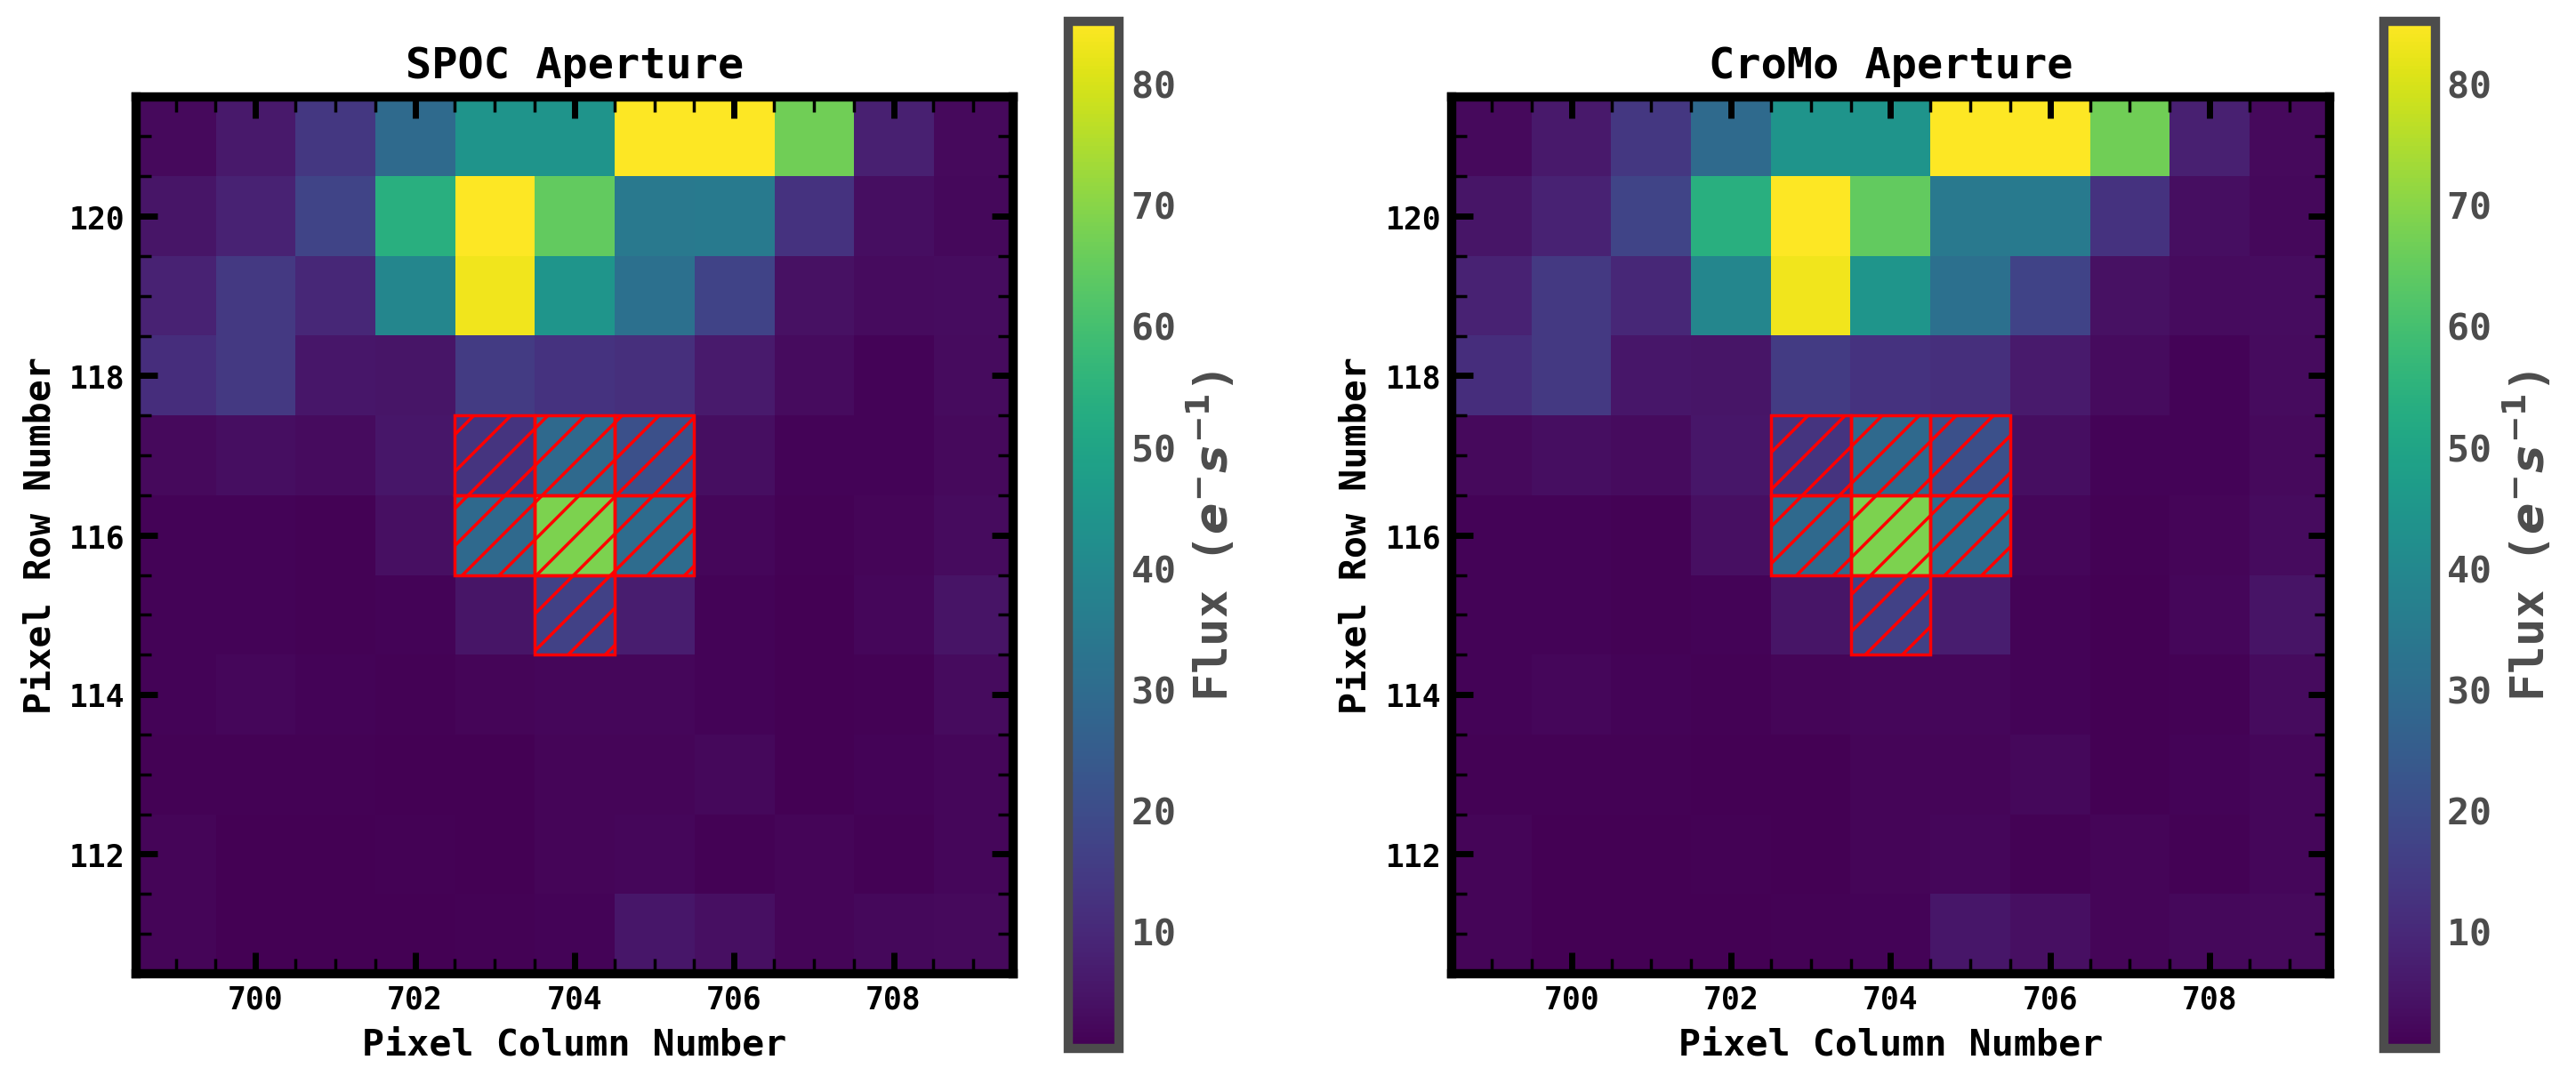

In [138]:
cromo_source_aperture, cromo_bkg_aperture = TESSCrowd.get_optimal_aperture(dx=dx, dy=dy, snr_limit=3)

crowding=TESSCrowd.get_contamination_ratio(aperture=cromo_source_aperture)

fig, axes = plt.subplots(1, 2, figsize=(14,6))
tpf.plot(ax=axes[0], aperture_mask=tpf.pipeline_mask, )
tpf.plot(ax=axes[1], aperture_mask=cromo_source_aperture)

axes[0].set_title('SPOC Aperture', fontsize=14)
axes[1].set_title('CroMo Aperture', fontsize=14)

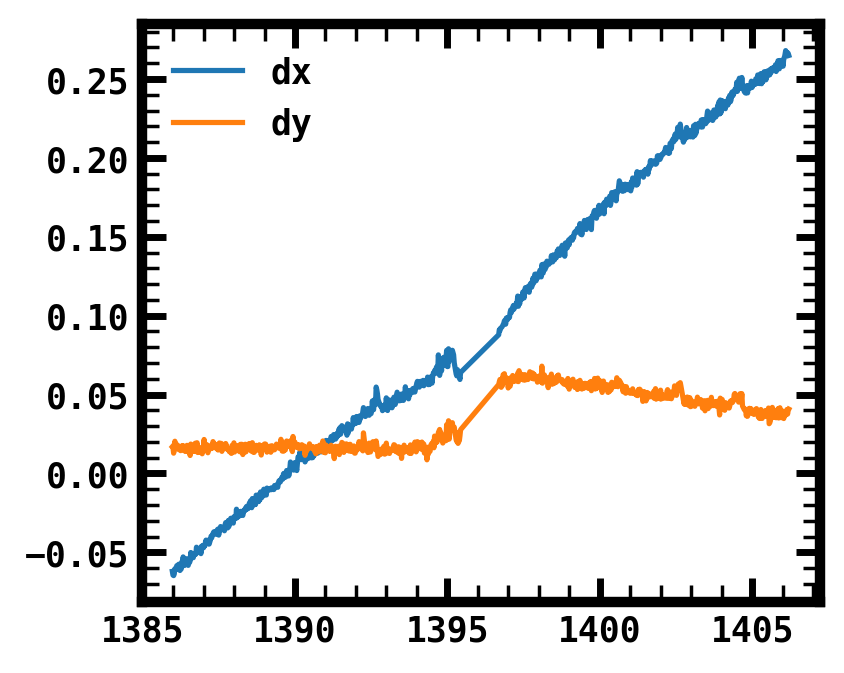

In [139]:
dxdt = TESSCrowd.get_xy_timeseries(dx=dx, dy=dy)

dx_t, dy_t = np.array(dxdt).T

plt.plot(tpf.time.value, dx_t, label='dx')
plt.plot(tpf.time.value, dy_t, label='dy')

plt.legend()

In [140]:
%time lcfits = TESSCrowd.get_prf_flux_timeseries()


CPU times: user 3.35 s, sys: 16.5 ms, total: 3.37 s
Wall time: 3.38 s


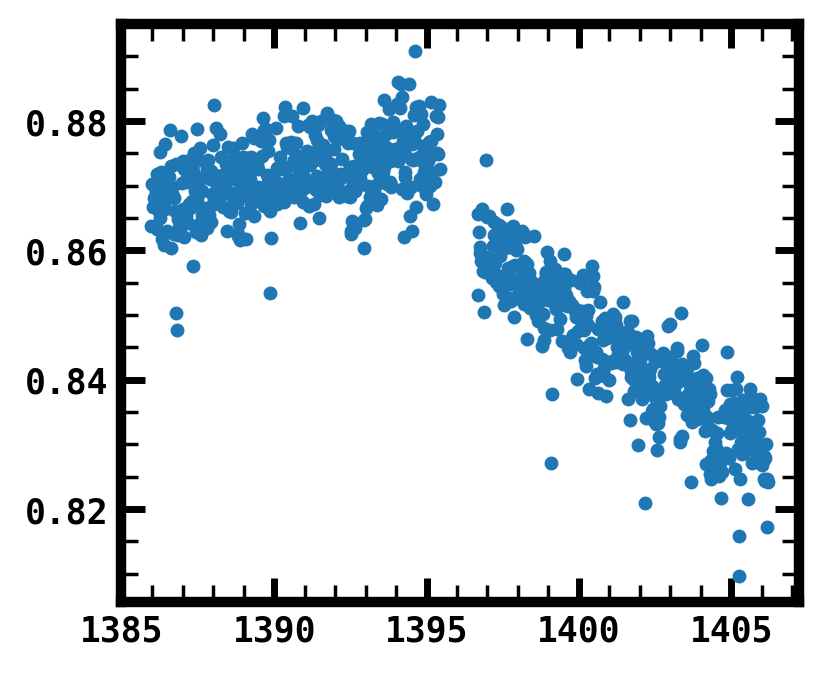

In [141]:
source, bkgstars, bkg = lcfits.T

sap_lc = [np.sum(f[cromo_source_aperture]) - bkg[i]*np.sum(cromo_source_aperture) for i,f in enumerate(tpf.flux.value)]
sap_lc_decrowd = (np.array(sap_lc) - np.median(sap_lc))/crowding['flfrcsap'] +  np.median(sap_lc)

plt.plot(tpf.time.value, source, '.')

#plt.plot(tpf.time.value%3.21346, bkgstars, '.')
#plt.plot(tpf.time.value%3.21346, bkg, '.')

In [142]:
lc_search = lk.search_lightcurve('TOI 2406', mission='TESS', exptime=1800 )
lc_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,TESS-SPOC,1800,212957629,0.0
1,TESS Sector 03,2018,GSFC-ELEANOR-LITE,1800,212957629,0.0
2,TESS Sector 03,2018,TASOC,1800,212957629,0.0
3,TESS Sector 03,2018,TASOC,1800,212957629,0.0


In [143]:
lc_spoc = lc_search[0].download()
#lc_tglc=lc_search[4].download()
lc_elnr=lc_search[1].download()


CroMo PRF LC scatter:    0.005163060632841665
CroMo SAP LC scatter:    0.005232489307811283
SPOC SAP LC scatter:     0.005321085453033447
Eleanor SAP LC scatter:  0.004972994327545166


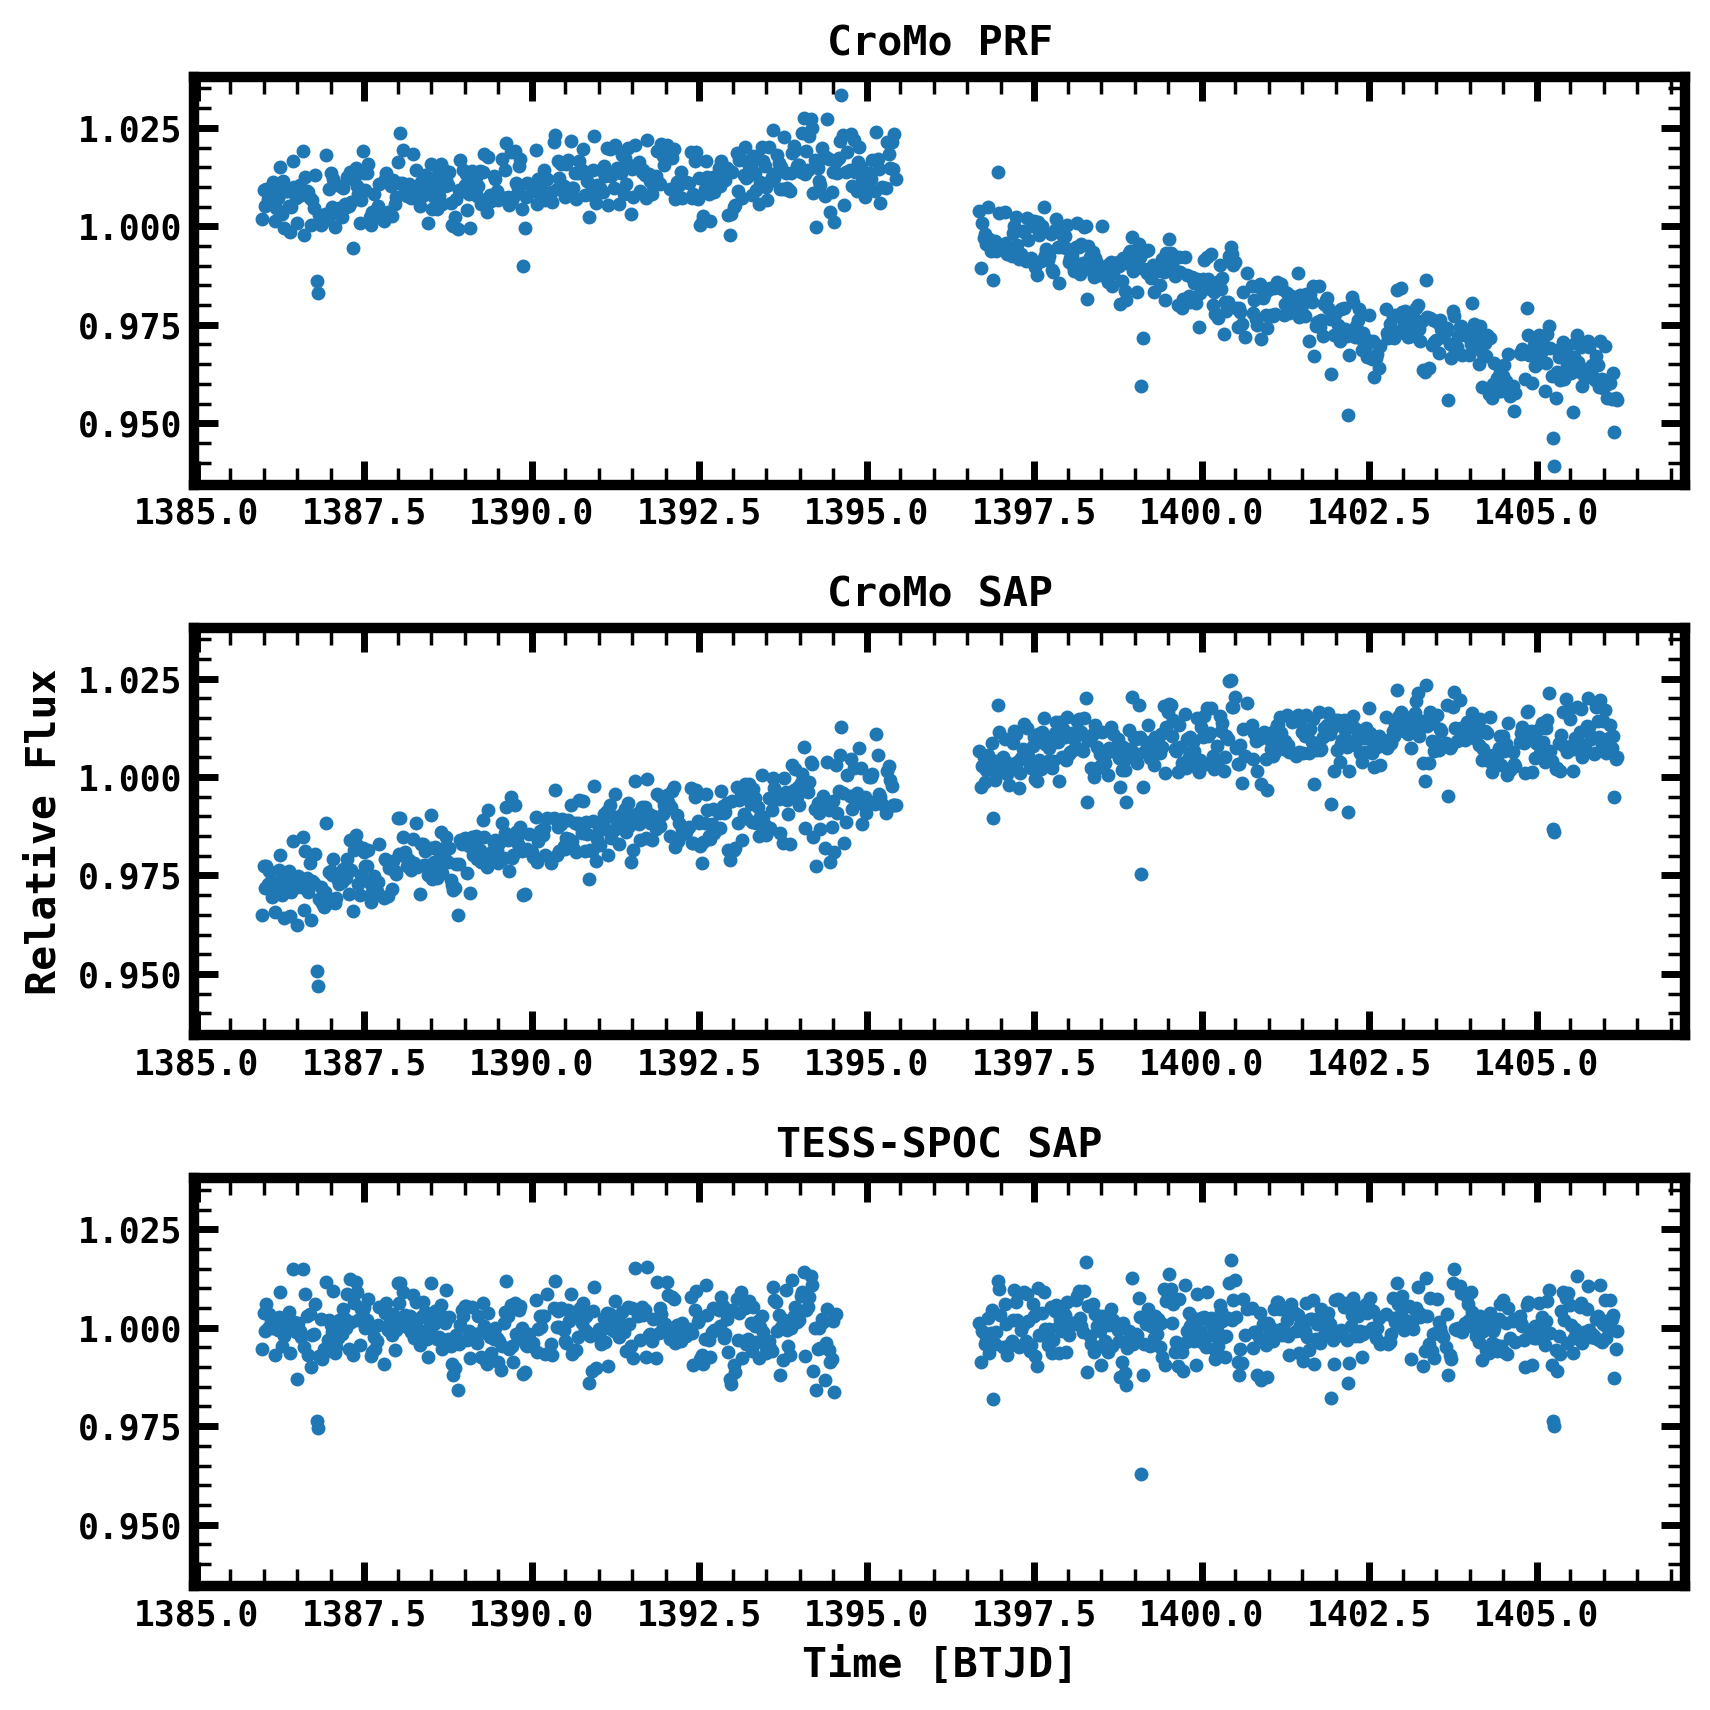

In [162]:
fig, axes = plt.subplots(3,1, figsize=(7,7), sharey=True, sharex=False)

P=3.0766e10

axes[0].plot(tpf.time.value%P, source/np.median(source), '.')
axes[1].plot(tpf.time.value%P, sap_lc_decrowd/np.median(sap_lc_decrowd), '.')
axes[2].plot(lc_spoc.time.value%P, lc_spoc.flux/np.median(lc_spoc.flux), '.')
#axes[3].plot(lc_elnr.time.value, lc_elnr.corr_flux/np.median(lc_elnr.corr_flux), '.')


axes[0].set_title('CroMo PRF')
axes[1].set_title('CroMo SAP')
axes[2].set_title('TESS-SPOC SAP')
#axes[3].set_title('Eleanor SAP')


axes[2].set_xlabel('Time [BTJD]')

axes[1].set_ylabel('Relative Flux')

#plt.ylim(.8, 1.06)

plt.tight_layout()


print('CroMo PRF LC scatter:   ', np.median(np.abs((source[1:]/np.median(source)-source[:-1]/np.median(source)))) )
print('CroMo SAP LC scatter:   ',np.median(np.abs((sap_lc_decrowd/np.median(sap_lc_decrowd))[1:]-(sap_lc_decrowd/np.median(sap_lc_decrowd))[:-1]) ) )
print('SPOC SAP LC scatter:    ',np.median(np.abs((lc_spoc.sap_flux/np.median(lc_spoc.sap_flux))[1:]-(lc_spoc.sap_flux/np.median(lc_spoc.sap_flux))[:-1]) ) )
print('Eleanor SAP LC scatter: ',np.median(np.abs((lc_elnr.flux/np.median(lc_elnr.flux))[1:]-(lc_elnr.flux/np.median(lc_elnr.flux))[:-1]) ) )

#plt.plot(tpf.time.value%3.21346, bkg, '.')

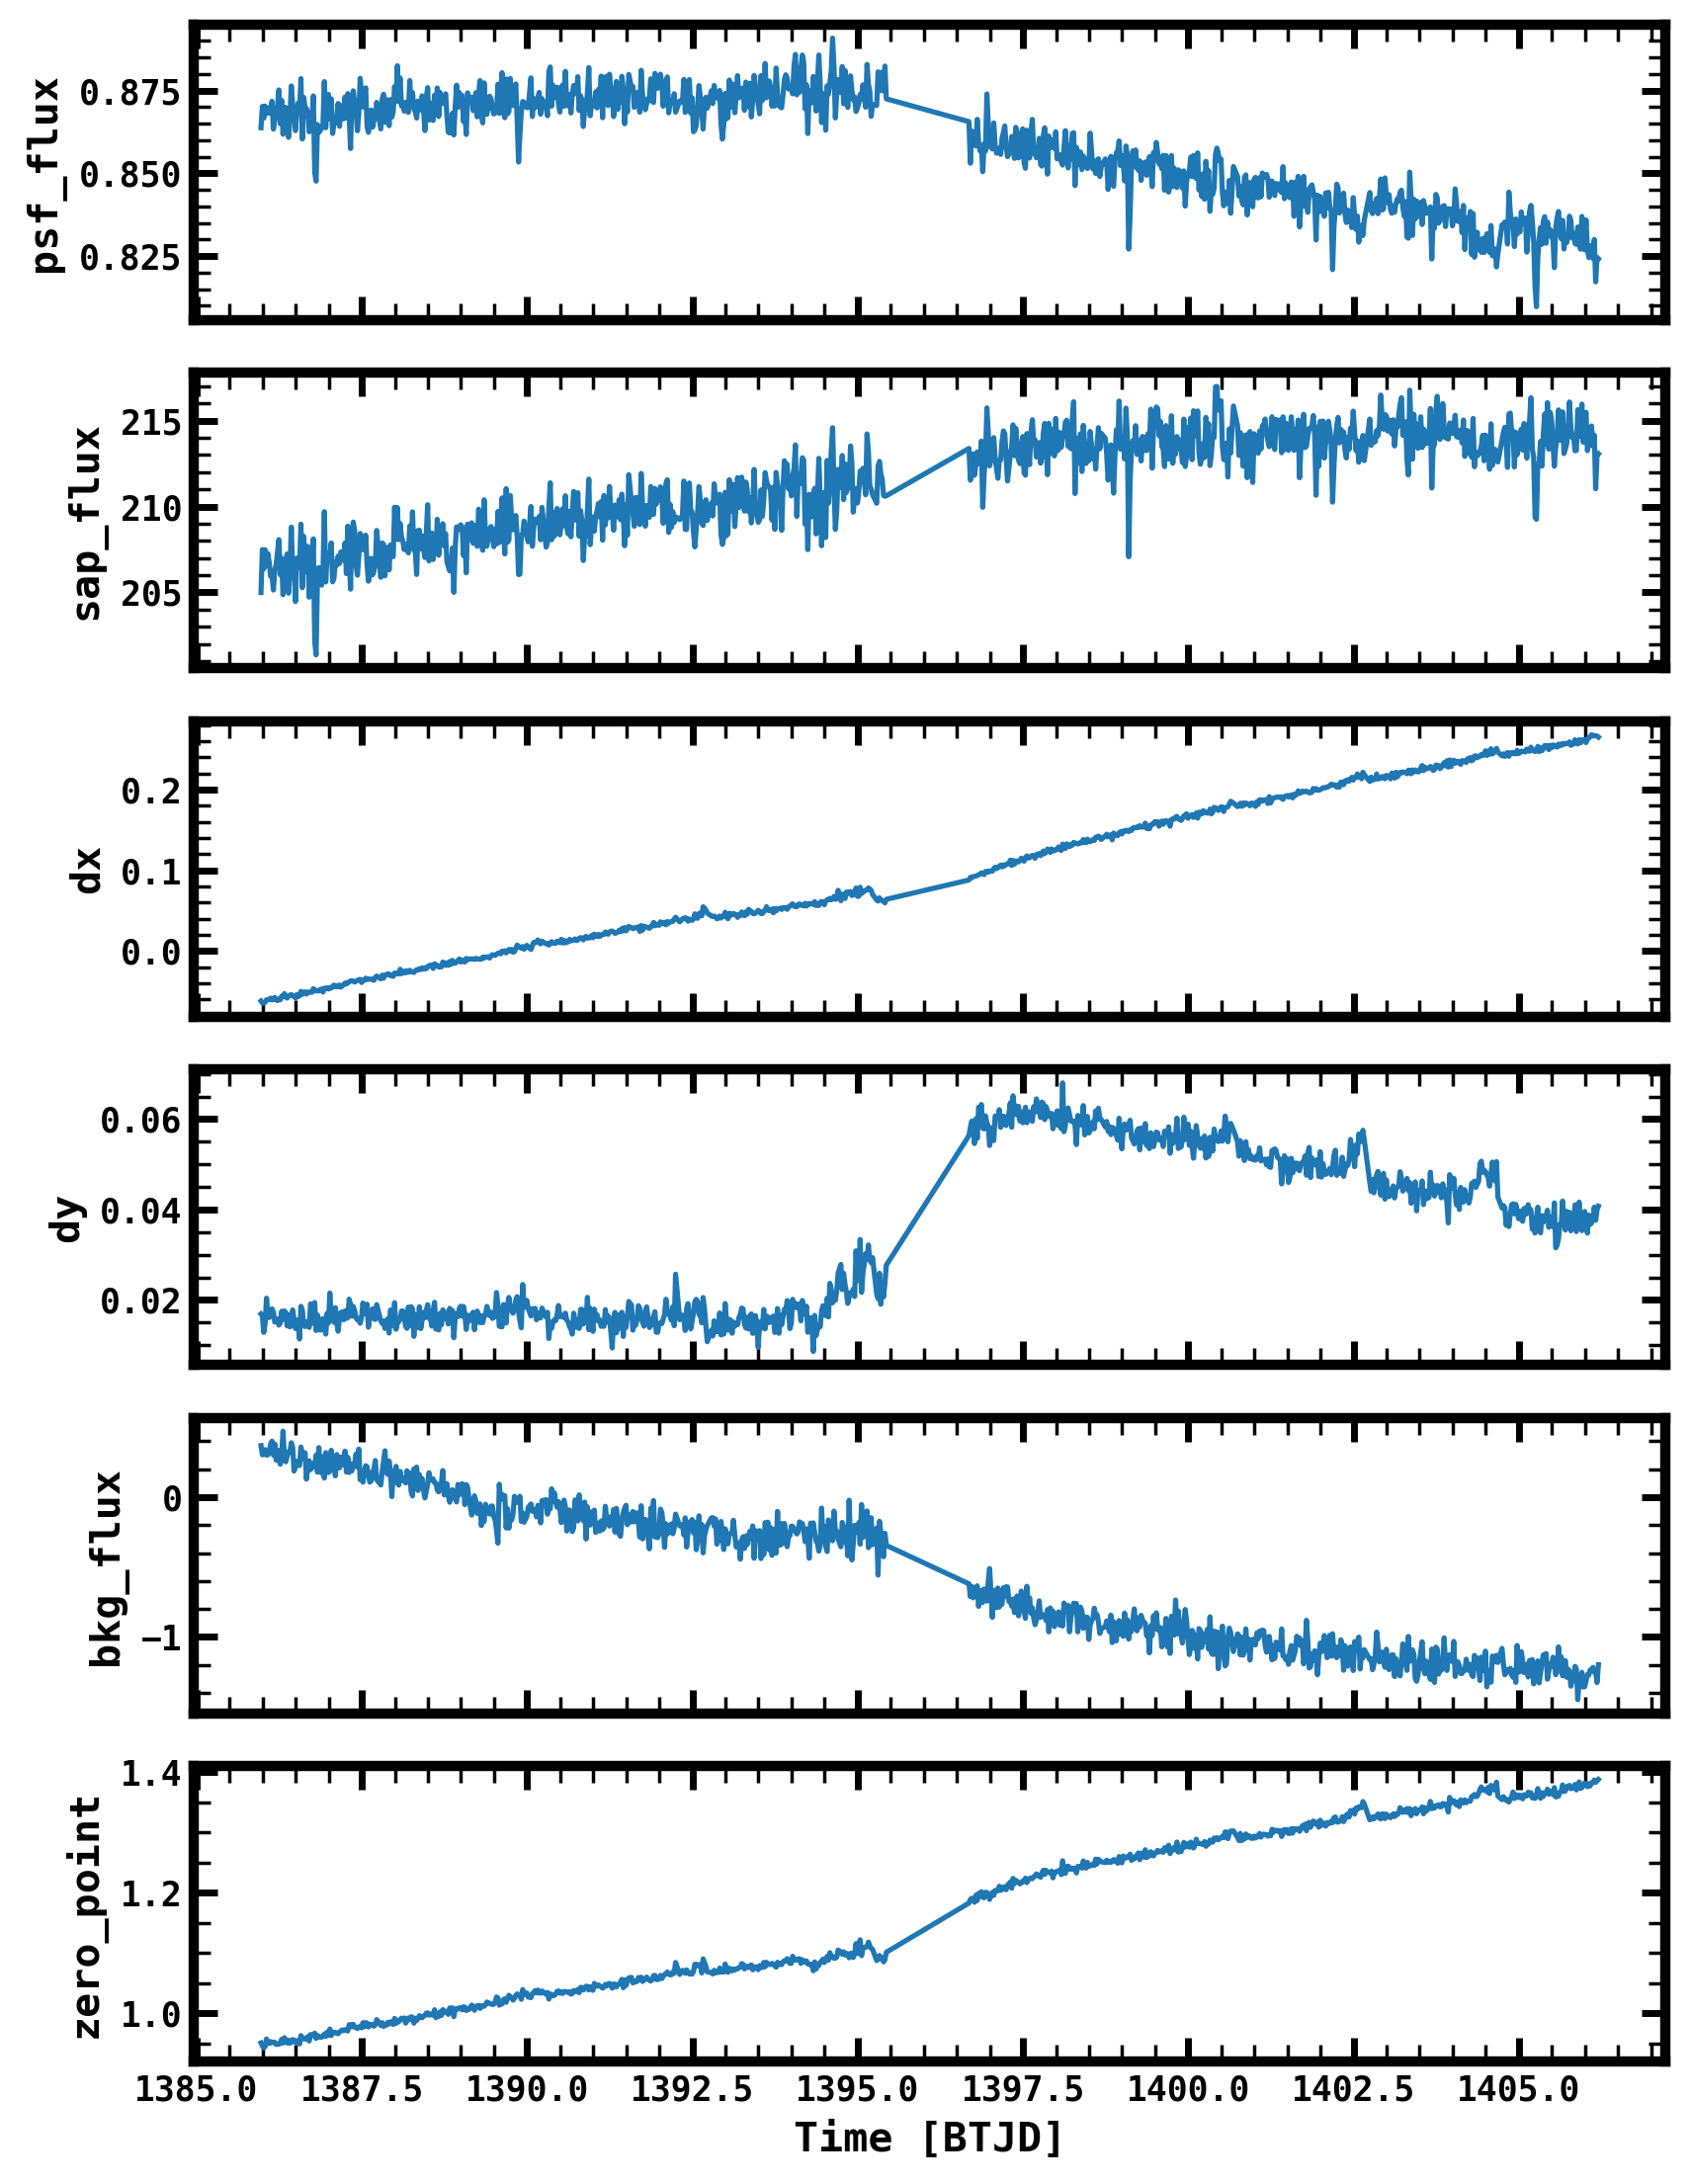

In [161]:
def norm(x):
    return x/np.median(x)


systematics=[source, sap_lc, dx_t, dy_t, bkg, bkgstars]
labels=['psf_flux','sap_flux','dx', 'dy', 'bkg_flux', 'zero_point']

fig, axes = plt.subplots(len(systematics), 1, figsize=(7, 1.5*len(systematics)), sharex=True)

for s in range(len(systematics)):

    axes[s].plot(tpf.time.value, systematics[s])
    axes[s].set_ylabel(labels[s])


axes[-1].set_xlabel('Time [BTJD]')

plt.tight_layout()
#plt.plot(norm(bkg) )
#plt.plot(norm(bkgstars)  )
